In [150]:
import importlib
import data 
importlib.reload(data)

<module 'data' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\interformer\\data.py'>

In [ ]:
import torch
from data import preprocess_all, prepare_prediction_window

In [79]:
condition_df = preprocess_all(
    "data/mm79158.csv",
    "data/slovenia_hourly_weather.csv",
    "data/slovenian_holidays_2016_2018.csv"
)

prediction_df = prepare_prediction_window(
    "data/slovenia_hourly_weather_future.csv",
    "data/slovenian_holidays_2019_2022.csv"
)



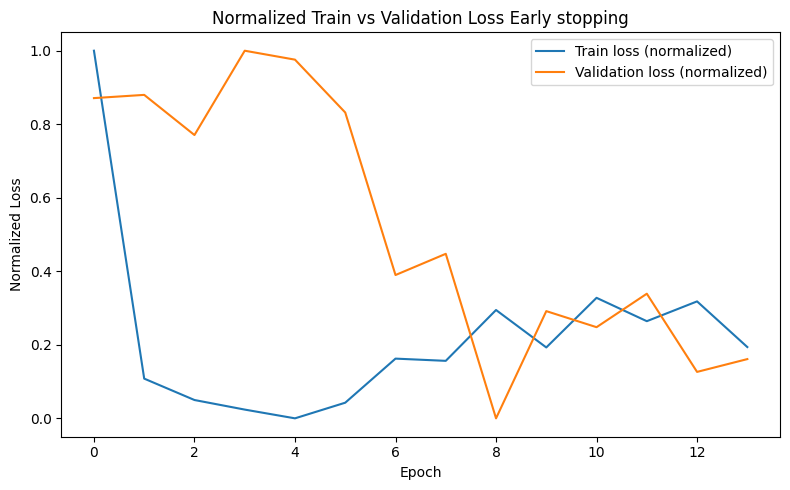

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('logs/log_trial3_lr0.01_clip1_bs256_dropout0.3_dmodel64_layers2_heads8_kernel2.csv')

# Min-max normalization
train_min = df['train_loss'].min()
train_max = df['train_loss'].max()
val_min = df['val_loss'].min()
val_max = df['val_loss'].max()

df['train_loss_norm'] = (df['train_loss'] - train_min) / (train_max - train_min)
df['val_loss_norm'] = (df['val_loss'] - val_min) / (val_max - val_min)

plt.figure(figsize=(8, 5))
plt.plot(df['train_loss_norm'].values, label="Train loss (normalized)", )
plt.plot(df['val_loss_norm'].values, label="Validation loss (normalized)")
plt.title("Normalized Train vs Validation Loss Early stopping")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [155]:
# === Config ===
INPUT_LEN = 24            # e.g., 1 day hourly
FORECAST_LEN = 12         # e.g., 12 hours
QUANTILES = [0.1, 0.5, 0.9]
TRIALS = 5
EPOCHS = 30

# === Device Setup ===
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)

MODEL_PATH = 'models/model_trial3_lr0.01_clip1_bs256_dropout0.3_dmodel64_layers2_heads8_kernel2.pth'
model = torch.load(MODEL_PATH)

CUDA available: True
Using GPU: NVIDIA GeForce RTX 4060


C:\Users\janav\AppData\Local\Temp\ipykernel_8928\2257806797.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)


In [147]:
condition_df = preprocess_all(
    "data/mm79158.csv",
    "data/slovenia_hourly_weather.csv",
    "data/slovenian_holidays_2016_2018.csv"
)
prediction_df = prepare_prediction_window(
    "data/slovenia_hourly_weather_future.csv",
    "data/slovenian_holidays_2019_2022.csv"
)

In [152]:
from data import prepare_interformer_dataloaders_and_prediction
train_loader, val_loader, test_loader, x_pred, scaler_x, scaler_y = prepare_interformer_dataloaders_and_prediction(
    condition_df, prediction_df,
    input_len=INPUT_LEN,
    forecast_len=FORECAST_LEN,
    batch_size=256
)

✔️ Sliding windows → X shape: (30228, 24, 46), y shape: (30228, 12)
📊 Dataset split → Train: 18138, Val: 3022, Test: 9068
🔃 Scaling X (features) and y (forecast sequence)...
✅ Prepared all data | X_cond shape, X_pred shape: (torch.Size([1, 24, 45]), torch.Size([1, 12, 45]))


C:\Users\janav\AppData\Local\Temp\ipykernel_8928\2893412436.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH, map_location=device)


📉 Test MAE (median forecast): 1.5326
📉 Test MAPE (median forecast): 0.6779
📉 Test MSE (median forecast): 2.3445


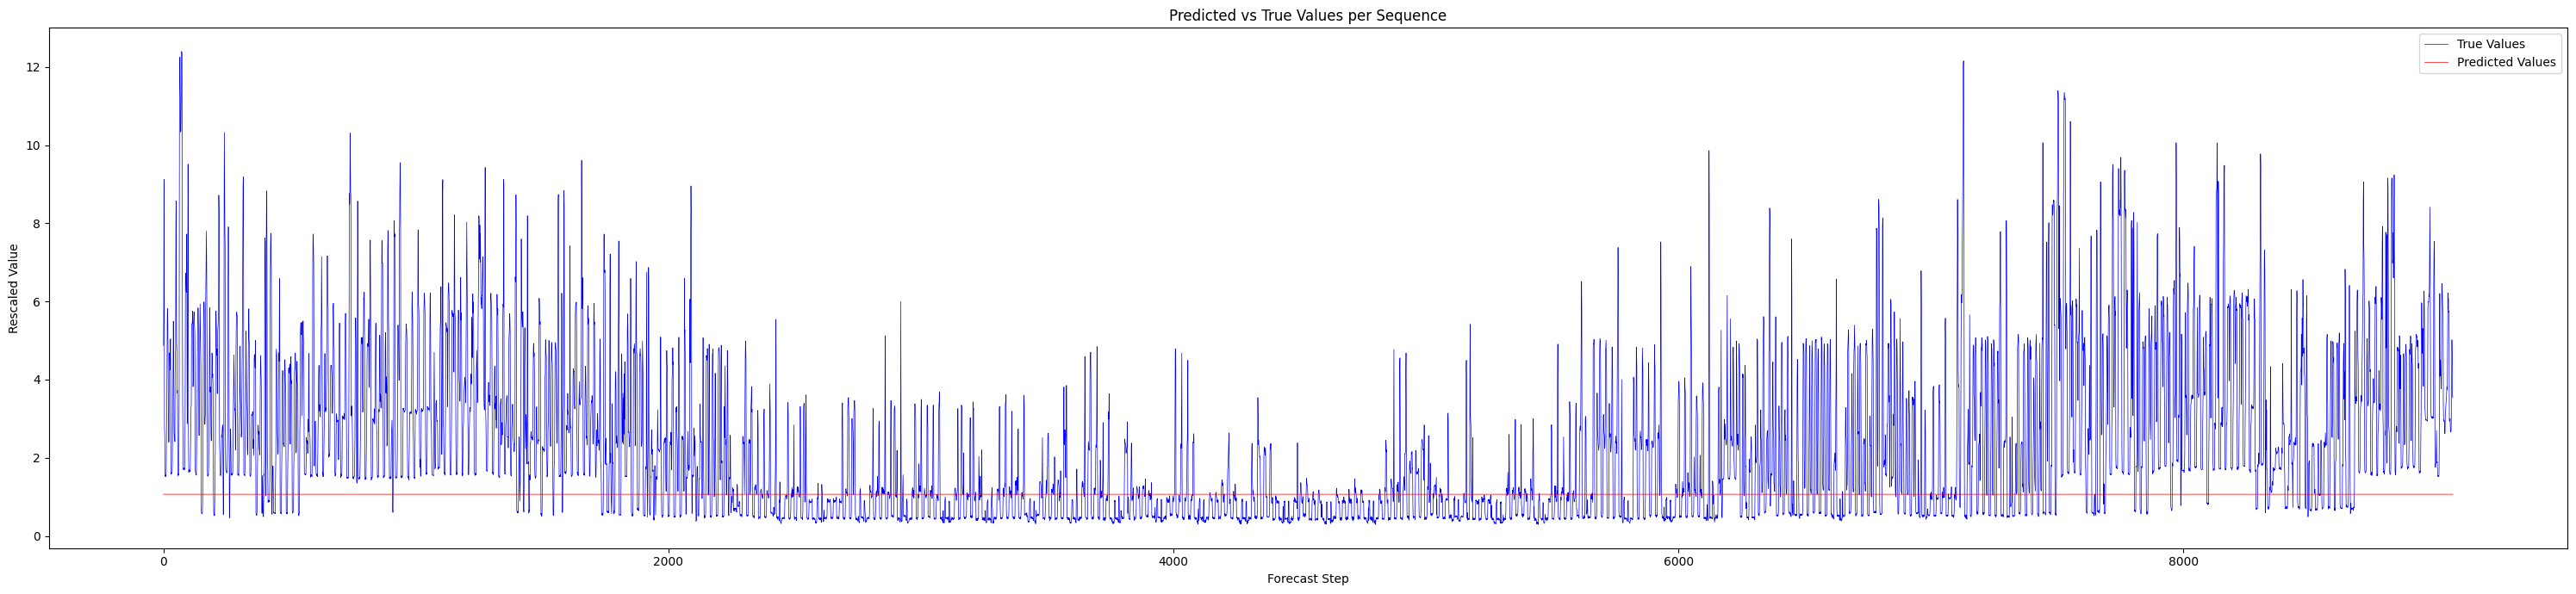

In [156]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

model = torch.load(MODEL_PATH, map_location=device)
model.to(device)
model.eval()

# === Predict on test set
y_true = []
y_pred = []

with torch.no_grad():
    for x_cond, y in test_loader:
        x_cond, y = x_cond.to(device), y.to(device)
        x_pred_batch = x_pred.repeat(x_cond.size(0), 1, 1).to(device)

        preds, *_ = model(x_cond, x_pred_batch)  # [B, Q, H]
        median_preds = preds[:, 1, :]  # take 0.5 quantile for comparison

        y_true.append(y.cpu().numpy())
        y_pred.append(median_preds.cpu().numpy())

y_true = np.concatenate(y_true, axis=0)   # [N, H]
y_pred = np.concatenate(y_pred, axis=0)   # [N, H]

# === Invert scaling if needed
# === Invert scaling if needed
# === Invert scaling ONLY on 'vrednost'

vred_index = list(condition_df.columns).index('vrednost')
min_v = scaler_y.data_min_[vred_index]
max_v = scaler_y.data_max_[vred_index]

def invert_scaled(y):
    return y * (max_v - min_v) + min_v

y_true = invert_scaled(y_true)
y_pred = invert_scaled(y_pred)

# === Metrics
mae = mean_absolute_error(y_true, y_pred)
print(f"📉 Test MAE (median forecast): {mae:.4f}")
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"📉 Test MAPE (median forecast): {mape:.4f}")
rmse = root_mean_squared_error(y_true, y_pred)
print(f"📉 Test MSE (median forecast): {rmse:.4f}")


plt.figure(figsize=(30, 7))
plt.plot(y_true[:, 0], color='blue', linewidth=0.5, label='True Values')
plt.plot(y_pred[:, 0], color='red', linewidth=0.5, label='Predicted Values')
plt.title("Predicted vs True Values per Sequence")
plt.xlabel("Forecast Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()

In [138]:
print("Sample median predictions:", y_pred[:5])
print("Sample true values:", y_true[:5])


Sample median predictions: [[20.307518 18.931658 18.402132 19.14324  17.555464 19.35071  20.101574
  18.576765 18.503271 21.690609 19.944654 19.294914]
 [20.30749  18.931622 18.40215  19.143192 17.555527 19.35068  20.101591
  18.576717 18.50332  21.690645 19.944687 19.294971]
 [20.307484 18.93157  18.402218 19.1432   17.555525 19.350721 20.101635
  18.576653 18.50333  21.690672 19.944696 19.295002]
 [20.307457 18.931507 18.402254 19.143167 17.555582 19.35071  20.101667
  18.57661  18.503384 21.690712 19.944727 19.295063]
 [20.307442 18.93142  18.402256 19.143139 17.555626 19.350693 20.101727
  18.576593 18.503448 21.690771 19.94478  19.295113]]
Sample true values: [[ 65.39872   79.59552  122.17755   89.06005   37.423172  34.095535
   21.203037  20.542526  20.94385   21.161232  20.58433   24.731335]
 [ 79.59552  122.17755   89.06005   37.423172  34.095535  21.203037
   20.542526  20.94385   21.161232  20.58433   24.731335  38.209095]
 [122.17755   89.06005   37.423172  34.095535  21.203